<a href="https://colab.research.google.com/github/PercyMayaba/-Prescriptive-Blood-Testing-Analytics-with-PySpark/blob/main/PrescriptiveBloodTesting_AnalyticswithPySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install and Setup PySpark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark pyspark_dist_explore matplotlib seaborn scikit-learn

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

print("PySpark setup completed!")

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,125 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [38.5 kB]
Get:13 http://archive.ubuntu.com/ubuntu 

In [ ]:
# Cell 2: Initialize Spark Session and Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create Spark Session
spark = SparkSession.builder \
    .appName("PrescriptiveBloodTesting") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark session created!")

Spark session created!


In [ ]:
# Cell 3: Generate Synthetic Blood Test Data
def generate_synthetic_blood_data(num_patients=10000):
    np.random.seed(42)

    # Patient demographics
    ages = np.random.normal(45, 15, num_patients).astype(int)
    ages = np.clip(ages, 18, 90)
    genders = np.random.choice(['M', 'F'], num_patients, p=[0.48, 0.52])

    # Blood test parameters with realistic correlations
    # Hemoglobin (g/dL)
    hemoglobin = np.random.normal(14, 2, num_patients)
    hemoglobin = np.clip(hemoglobin, 8, 20)

    # WBC count (thousands/μL)
    wbc = np.random.normal(7, 2, num_patients)
    wbc = np.clip(wbc, 2, 15)

    # Platelets (thousands/μL)
    platelets = np.random.normal(250, 50, num_patients)
    platelets = np.clip(platelets, 100, 500)

    # Glucose (mg/dL) - correlated with age
    glucose = np.random.normal(100 + (ages-45)*0.3, 15, num_patients)
    glucose = np.clip(glucose, 70, 200)

    # Cholesterol (mg/dL)
    cholesterol = np.random.normal(190, 30, num_patients)
    cholesterol = np.clip(cholesterol, 120, 300)

    # Creatinine (mg/dL) - higher for males and older patients
    creatinine_base = np.where(genders == 'M', 1.0, 0.8)
    creatinine = np.random.normal(creatinine_base + (ages-45)*0.005, 0.2, num_patients)
    creatinine = np.clip(creatinine, 0.5, 2.5)

    # Generate risk flags based on test results
    anemia_flag = (hemoglobin < 12) & (genders == 'F') | (hemoglobin < 13) & (genders == 'M')
    diabetes_risk = glucose > 126
    high_cholesterol = cholesterol > 200
    kidney_risk = creatinine > 1.2

    # Composite risk score
    risk_score = (anemia_flag.astype(int) + diabetes_risk.astype(int) +
                 high_cholesterol.astype(int) + kidney_risk.astype(int))

    # Recommended test frequency (in months) based on risk
    test_frequency = np.where(risk_score >= 3, 3,
                             np.where(risk_score >= 2, 6,
                                     np.where(risk_score >= 1, 12, 24)))

    data = pd.DataFrame({
        'patient_id': range(1, num_patients + 1),
        'age': ages,
        'gender': genders,
        'hemoglobin': hemoglobin,
        'wbc_count': wbc,
        'platelets': platelets,
        'glucose': glucose,
        'cholesterol': cholesterol,
        'creatinine': creatinine,
        'anemia_risk': anemia_flag.astype(int),
        'diabetes_risk': diabetes_risk.astype(int),
        'high_cholesterol_flag': high_cholesterol.astype(int),
        'kidney_risk_flag': kidney_risk.astype(int),
        'composite_risk_score': risk_score,
        'recommended_test_freq_months': test_frequency
    })

    return data

# Generate and display synthetic data
blood_data_pd = generate_synthetic_blood_data(10000)
blood_df = spark.createDataFrame(blood_data_pd)

print("Synthetic Blood Test Data Generated:")
print(f"Total patients: {blood_df.count()}")
blood_df.show(10)

Synthetic Blood Test Data Generated:
Total patients: 10000
+----------+---+------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-------------+---------------------+----------------+--------------------+----------------------------+
|patient_id|age|gender|        hemoglobin|         wbc_count|         platelets|           glucose|       cholesterol|        creatinine|anemia_risk|diabetes_risk|high_cholesterol_flag|kidney_risk_flag|composite_risk_score|recommended_test_freq_months|
+----------+---+------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-------------+---------------------+----------------+--------------------+----------------------------+
|         1| 52|     M|13.041081178099082|  7.67769419288322| 255.4066721143733| 120.8252089802342|207.42685967846165| 1.064130143429433|          0|            0|                   

=== Data Summary Statistics ===
+-------+------------------+------------------+------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------------------+--------------------+----------------------------+
|summary|        patient_id|               age|gender|        hemoglobin|         wbc_count|         platelets|           glucose|       cholesterol|         creatinine|       anemia_risk|      diabetes_risk|high_cholesterol_flag|   kidney_risk_flag|composite_risk_score|recommended_test_freq_months|
+-------+------------------+------------------+------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------------------+--------------------+----------------------------+
|  count|             10000|             10000| 10000|           

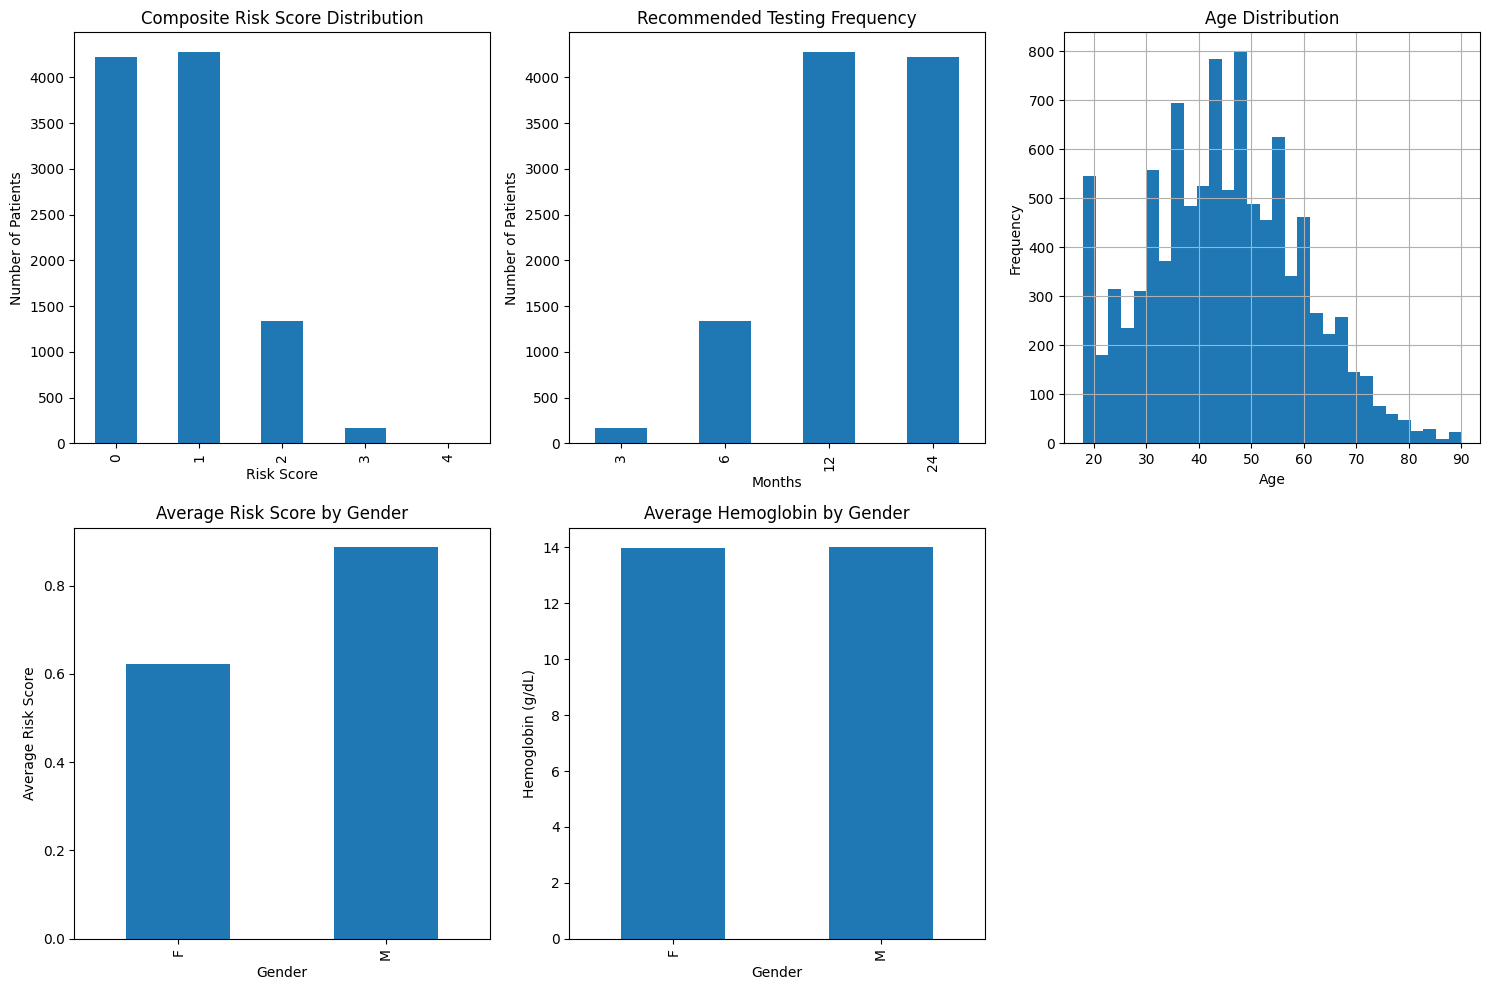

In [ ]:
# Cell 4: Data Exploration and Analysis
print("=== Data Summary Statistics ===")
blood_df.describe().show()

print("\n=== Risk Distribution ===")
blood_df.groupBy("composite_risk_score").count().orderBy("composite_risk_score").show()

print("\n=== Recommended Testing Frequency Distribution ===")
blood_df.groupBy("recommended_test_freq_months").count().orderBy("recommended_test_freq_months").show()

# Convert to Pandas for visualization
blood_pd = blood_df.toPandas()

# Visualization 1: Risk Score Distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
blood_pd['composite_risk_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Composite Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Number of Patients')

plt.subplot(2, 3, 2)
blood_pd['recommended_test_freq_months'].value_counts().sort_index().plot(kind='bar')
plt.title('Recommended Testing Frequency')
plt.xlabel('Months')
plt.ylabel('Number of Patients')

plt.subplot(2, 3, 3)
blood_pd['age'].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
blood_pd.groupby('gender')['composite_risk_score'].mean().plot(kind='bar')
plt.title('Average Risk Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Risk Score')

plt.subplot(2, 3, 5)
blood_pd.groupby('gender')['hemoglobin'].mean().plot(kind='bar')
plt.title('Average Hemoglobin by Gender')
plt.xlabel('Gender')
plt.ylabel('Hemoglobin (g/dL)')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 5: Feature Engineering for Predictive Modeling
# Prepare features for machine learning
feature_columns = ['age', 'hemoglobin', 'wbc_count', 'platelets', 'glucose', 'cholesterol', 'creatinine']

# Convert gender to numerical
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")

# Assemble features
assembler = VectorAssembler(
    inputCols=feature_columns + ['gender_index'],
    outputCol="features"
)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Create pipeline for feature engineering
feature_pipeline = Pipeline(stages=[gender_indexer, assembler, scaler])

# Fit and transform the data
feature_model = feature_pipeline.fit(blood_df)
blood_featured_df = feature_model.transform(blood_df)

print("Feature Engineering Completed:")
blood_featured_df.select("features", "scaled_features", "composite_risk_score").show(5, truncate=False)

Feature Engineering Completed:
+-------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|features                                                                                                                 |scaled_features                                                                                                                                     |composite_risk_score|
+-------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|[52.0,13.041081178099082,7.67769419288322,255.4066721143733,120.8252089802342,207.4268

In [ ]:
# Cell 6: Predictive Model 1 - Risk Classification
# Split data for training and testing
train_df, test_df = blood_featured_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_df.count()} records")
print(f"Test set: {test_df.count()} records")

# Train Random Forest Classifier for risk prediction
rf_classifier = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="composite_risk_score",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Train the model
rf_model = rf_classifier.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

print("Risk Classification Model Results:")
predictions.select("composite_risk_score", "prediction", "probability").show(10)

# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Instantiate the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="composite_risk_score",
    predictionCol="prediction",
    metricName="accuracy"  # You can change this to "f1", "weightedPrecision", "weightedRecall"
)

# Calculate evaluation metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})


print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

Training set: 8053 records
Test set: 1947 records
Risk Classification Model Results:
+--------------------+----------+--------------------+
|composite_risk_score|prediction|         probability|
+--------------------+----------+--------------------+
|                   0|       0.0|[0.97891418645201...|
|                   3|       3.0|[0.0,0.0106722689...|
|                   0|       0.0|[0.98315843695187...|
|                   1|       1.0|[0.01125000000000...|
|                   0|       0.0|[0.97403808964080...|
|                   0|       0.0|[0.99201951844839...|
|                   0|       0.0|[0.98897337841305...|
|                   1|       1.0|[0.01000000000000...|
|                   1|       1.0|[0.00782407407407...|
|                   2|       2.0|[0.0,0.0620592450...|
+--------------------+----------+--------------------+
only showing top 10 rows


Model Performance:
Accuracy: 0.9810
F1 Score: 0.9810
Weighted Precision: 0.9811
Weighted Recall: 0.9810


In [ ]:
# Cell 7: Predictive Model 2 - Test Frequency Recommendation
# Train regression model for test frequency recommendation
lr_regressor = LinearRegression(
    featuresCol="scaled_features",
    labelCol="recommended_test_freq_months",
    maxIter=100
)

# Train the model
lr_model = lr_regressor.fit(train_df)

# Make predictions
freq_predictions = lr_model.transform(test_df)

print("Test Frequency Recommendation Results:")
freq_predictions.select("recommended_test_freq_months", "prediction").show(10)

# Evaluate regression model
reg_evaluator = RegressionEvaluator(
    labelCol="recommended_test_freq_months",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = reg_evaluator.evaluate(freq_predictions)
r2 = reg_evaluator.evaluate(freq_predictions, {reg_evaluator.metricName: "r2"})

print(f"\nRegression Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Frequency Recommendation Results:
+----------------------------+------------------+
|recommended_test_freq_months|        prediction|
+----------------------------+------------------+
|                          24|16.637037623148885|
|                           3| 7.229174767127908|
|                          24|21.116212973199097|
|                          12|12.380347089317695|
|                          24| 16.66769565036352|
|                          24|18.235255664145676|
|                          24|22.338356809560395|
|                          12|  13.7605124687468|
|                          12| 15.19984163088704|
|                           6| 9.811195982059711|
+----------------------------+------------------+
only showing top 10 rows


Regression Model Performance:
RMSE: 5.0083
R² Score: 0.5096


In [ ]:
# Cell 8: Patient Clustering for Personalized Recommendations
# Use K-means to cluster patients based on their blood profiles
kmeans = KMeans(
    featuresCol="scaled_features",
    k=4,  # 4 patient clusters
    seed=42
)

# Train clustering model
kmeans_model = kmeans.fit(blood_featured_df)

# Get cluster predictions
clustered_df = kmeans_model.transform(blood_featured_df)

print("Patient Clustering Results:")
clustered_df.groupBy("prediction").count().orderBy("prediction").show()

# Analyze cluster characteristics
cluster_stats = clustered_df.groupBy("prediction").agg(
    mean("age").alias("avg_age"),
    mean("hemoglobin").alias("avg_hemoglobin"),
    mean("glucose").alias("avg_glucose"),
    mean("cholesterol").alias("avg_cholesterol"),
    mean("creatinine").alias("avg_creatinine"),
    mean("composite_risk_score").alias("avg_risk_score"),
    mean("recommended_test_freq_months").alias("avg_test_freq")
).orderBy("prediction")

print("Cluster Characteristics:")
cluster_stats.show()

Patient Clustering Results:
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2720|
|         1| 2476|
|         2| 2200|
|         3| 2604|
+----------+-----+

Cluster Characteristics:
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|prediction|           avg_age|    avg_hemoglobin|       avg_glucose|   avg_cholesterol|    avg_creatinine|    avg_risk_score|     avg_test_freq|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|         0|35.221691176470586| 13.89347366581047| 91.40773708500448|193.20451930638802|0.7286456905010744|            0.5875|17.388970588235296|
|         1| 35.31017770597738|13.955764532602691| 93.10804429477311|190.58694283087232|0.8957832118280188|0.7253634894991923|16.159531502423263|
|         2| 55.22318181818182|14.071124632560508| 107.764710579

In [ ]:
# Cell 9: Prescriptive Analytics - Generate Personalized Recommendations
def generate_prescriptive_recommendations(clustered_df):
    """Generate personalized recommendations based on patient clusters and risk factors"""

    recommendations_df = clustered_df.withColumn(
        "personalized_recommendation",
        when(col("prediction") == 0,
             "Low risk: Annual comprehensive blood panel recommended. Maintain healthy lifestyle.")
        .when(col("prediction") == 1,
              "Moderate risk: Semi-annual monitoring recommended. Focus on diet and exercise.")
        .when(col("prediction") == 2,
              "High risk: Quarterly monitoring advised. Consult specialist for diabetes management.")
        .when(col("prediction") == 3,
              "Very high risk: Monthly monitoring required. Immediate specialist consultation recommended.")
        .otherwise("Standard annual checkup recommended.")
    ).withColumn(
        "specific_actions",
        when(col("glucose") > 126, "Monitor blood sugar regularly. Consider diabetes screening.")
        .when(col("cholesterol") > 200, "Focus on heart-healthy diet. Consider lipid-lowering therapy.")
        .when(col("creatinine") > 1.2, "Kidney function monitoring needed. Hydration important.")
        .when(col("hemoglobin") < 12, "Iron-rich diet recommended. Consider anemia workup.")
        .otherwise("Maintain current healthy practices.")
    )

    return recommendations_df

# Generate recommendations
prescriptive_df = generate_prescriptive_recommendations(clustered_df)

print("Prescriptive Recommendations Sample:")
prescriptive_df.select(
    "patient_id", "age", "gender", "composite_risk_score",
    "personalized_recommendation", "specific_actions"
).show(20, truncate=False)

Prescriptive Recommendations Sample:
+----------+---+------+--------------------+-------------------------------------------------------------------------------------------+-------------------------------------------------------------+
|patient_id|age|gender|composite_risk_score|personalized_recommendation                                                                |specific_actions                                             |
+----------+---+------+--------------------+-------------------------------------------------------------------------------------------+-------------------------------------------------------------+
|1         |52 |M     |1                   |High risk: Quarterly monitoring advised. Consult specialist for diabetes management.       |Focus on heart-healthy diet. Consider lipid-lowering therapy.|
|2         |42 |M     |3                   |High risk: Quarterly monitoring advised. Consult specialist for diabetes management.       |Focus on heart-healthy diet. Co

In [ ]:
# Cell 10: Resource Optimization - Testing Schedule Optimization
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, month, year

# Simulate creating an optimal testing schedule
def create_optimized_testing_schedule(prescriptive_df):
    """Create optimized testing schedule to balance workload and patient needs"""

    # Add random month for scheduling (simulating real scheduling scenario)
    optimized_schedule = prescriptive_df.withColumn(
        "preferred_test_month",
        (rand() * 11 + 1).cast("int")  # Random month 1-12
    ).withColumn(
        "testing_priority",
        when(col("composite_risk_score") >= 3, 1)  # Highest priority
        .when(col("composite_risk_score") == 2, 2)  # Medium priority
        .otherwise(3)  # Low priority
    ).withColumn(
        "estimated_test_duration_minutes",
        when(col("composite_risk_score") >= 3, 45)  # More comprehensive tests
        .when(col("composite_risk_score") == 2, 30)  # Standard tests
        .otherwise(20)  # Basic tests
    )

    return optimized_schedule

# Create optimized schedule
testing_schedule = create_optimized_testing_schedule(prescriptive_df)

print("Optimized Testing Schedule Sample:")
testing_schedule.select(
    "patient_id", "age", "composite_risk_score", "testing_priority",
    "preferred_test_month", "estimated_test_duration_minutes"
).orderBy("testing_priority", "preferred_test_month").show(20)

# Analyze monthly workload
monthly_workload = testing_schedule.groupBy("preferred_test_month").agg(
    count("patient_id").alias("patient_count"),
    sum("estimated_test_duration_minutes").alias("total_minutes"),
    avg("composite_risk_score").alias("avg_risk_score")
).orderBy("preferred_test_month")

print("\nMonthly Workload Distribution:")
monthly_workload.show()

Optimized Testing Schedule Sample:
+----------+---+--------------------+----------------+--------------------+-------------------------------+
|patient_id|age|composite_risk_score|testing_priority|preferred_test_month|estimated_test_duration_minutes|
+----------+---+--------------------+----------------+--------------------+-------------------------------+
|         2| 42|                   3|               1|                   1|                             45|
|      5138| 55|                   3|               1|                   1|                             45|
|      1303| 42|                   3|               1|                   1|                             45|
|      5645| 56|                   3|               1|                   1|                             45|
|      3579| 32|                   3|               1|                   1|                             45|
|      6430| 38|                   3|               1|                   1|                          

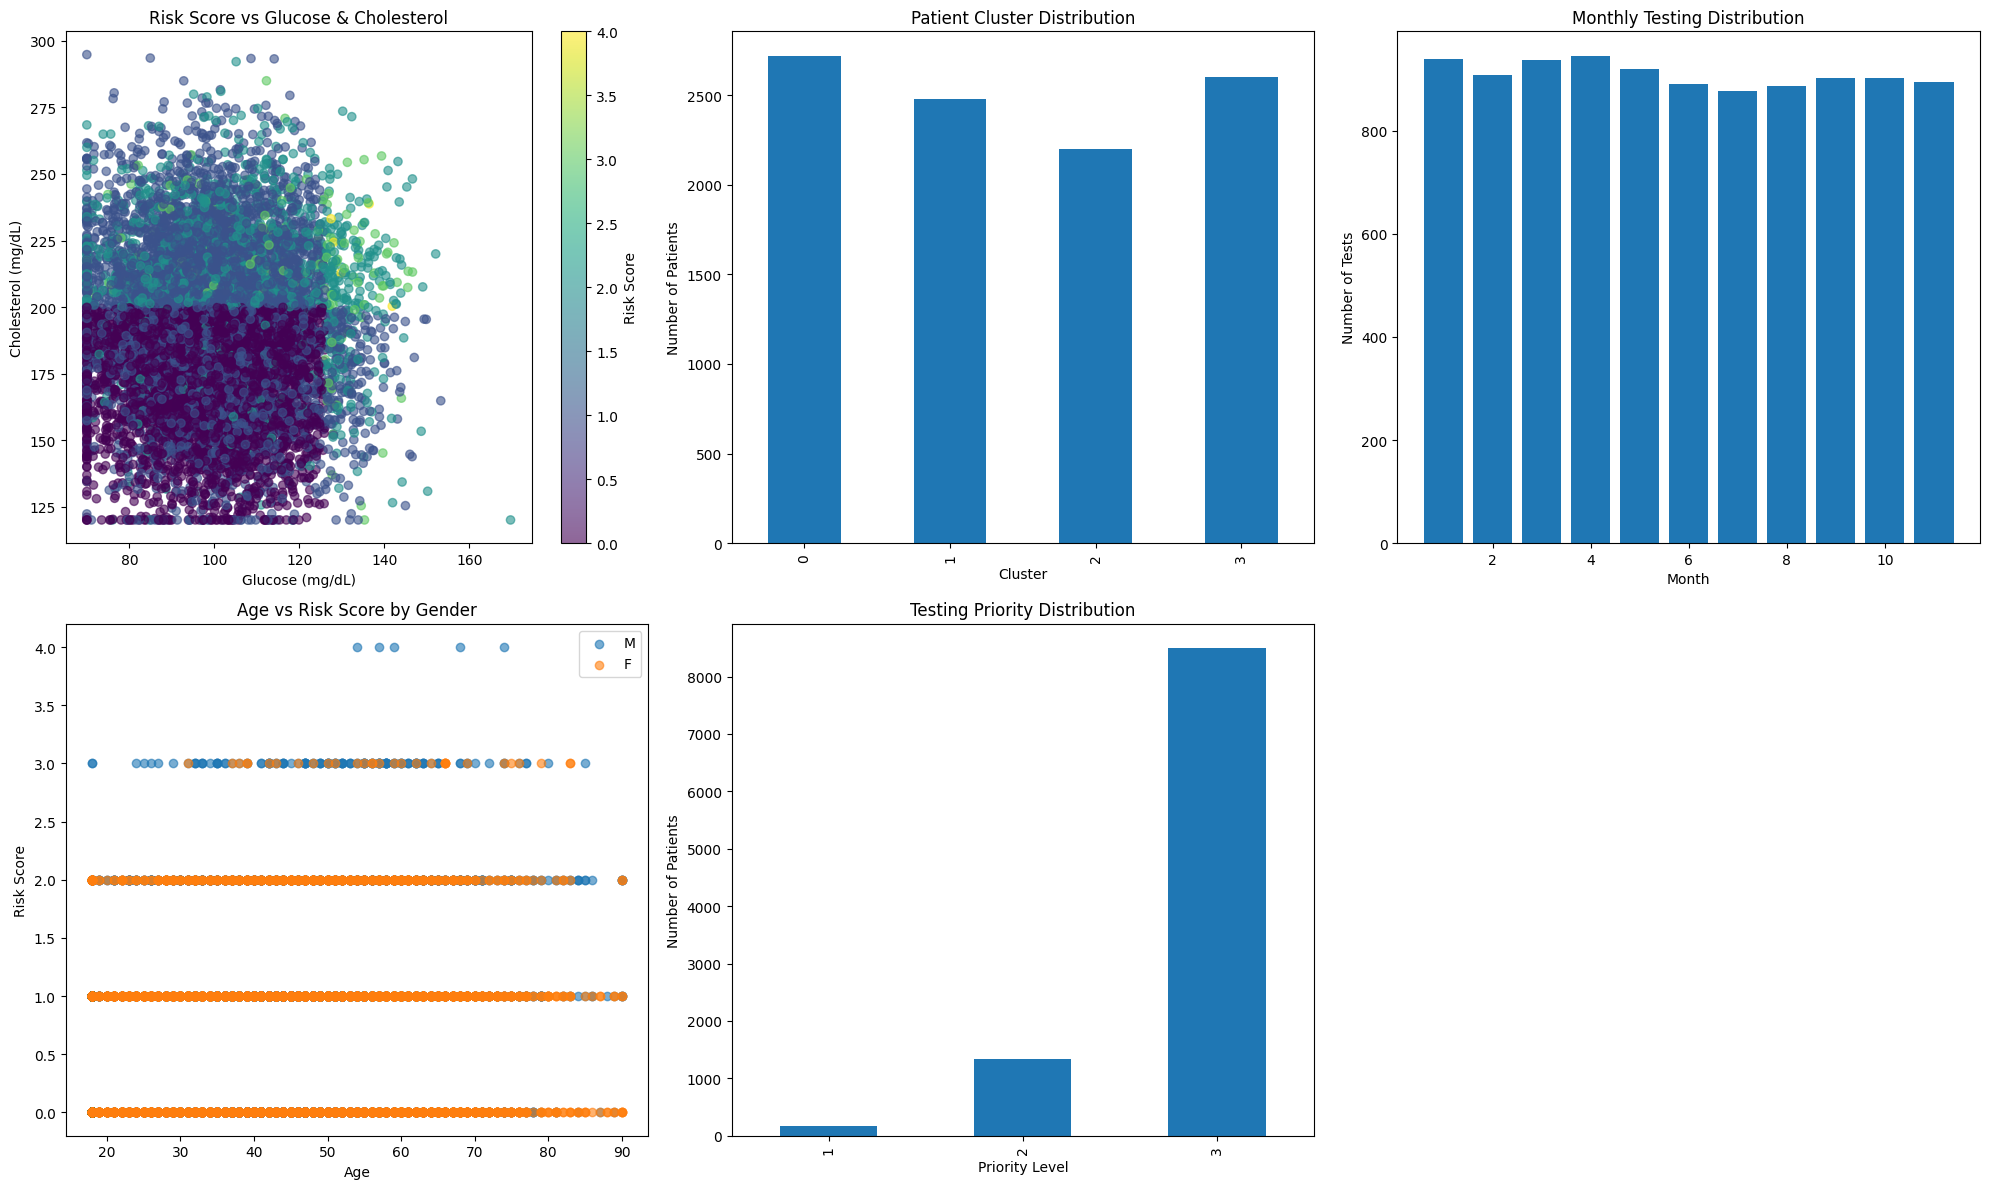

In [ ]:
# Cell 11: Visualization of Results
# Convert results to Pandas for visualization
results_pd = prescriptive_df.select(
    "age", "gender", "hemoglobin", "glucose", "cholesterol",
    "creatinine", "composite_risk_score", "prediction"
).toPandas()

schedule_pd = testing_schedule.select(
    "preferred_test_month", "testing_priority", "estimated_test_duration_minutes"
).toPandas()

# Create comprehensive visualizations
plt.figure(figsize=(20, 12))

# Plot 1: Risk Score vs Blood Parameters
plt.subplot(2, 3, 1)
plt.scatter(results_pd['glucose'], results_pd['cholesterol'],
           c=results_pd['composite_risk_score'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Risk Score')
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('Cholesterol (mg/dL)')
plt.title('Risk Score vs Glucose & Cholesterol')

# Plot 2: Cluster Distribution
plt.subplot(2, 3, 2)
results_pd['prediction'].value_counts().sort_index().plot(kind='bar')
plt.title('Patient Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')

# Plot 3: Monthly Workload
plt.subplot(2, 3, 3)
monthly_counts = schedule_pd['preferred_test_month'].value_counts().sort_index()
plt.bar(monthly_counts.index, monthly_counts.values)
plt.title('Monthly Testing Distribution')
plt.xlabel('Month')
plt.ylabel('Number of Tests')

# Plot 4: Age vs Risk Score by Gender
plt.subplot(2, 3, 4)
for gender in ['M', 'F']:
    subset = results_pd[results_pd['gender'] == gender]
    plt.scatter(subset['age'], subset['composite_risk_score'],
               label=gender, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Risk Score')
plt.legend()
plt.title('Age vs Risk Score by Gender')

# Plot 5: Testing Priority Distribution
plt.subplot(2, 3, 5)
schedule_pd['testing_priority'].value_counts().sort_index().plot(kind='bar')
plt.title('Testing Priority Distribution')
plt.xlabel('Priority Level')
plt.ylabel('Number of Patients')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 12: Business Intelligence and Reporting
# Generate comprehensive reports
print("=== PRESCRIPTIVE BLOOD TESTING ANALYTICS REPORT ===\n")

# Overall statistics
total_patients = blood_df.count()
high_risk_patients = blood_df.filter(col("composite_risk_score") >= 3).count()
avg_test_frequency = blood_df.agg(avg("recommended_test_freq_months")).collect()[0][0]

print(f"Total Patients Analyzed: {total_patients:,}")
print(f"High-Risk Patients (Score ≥3): {high_risk_patients:,} ({high_risk_patients/total_patients*100:.1f}%)")
print(f"Average Recommended Testing Frequency: {avg_test_frequency:.1f} months\n")

# Resource requirements
total_test_minutes = testing_schedule.agg(sum("estimated_test_duration_minutes")).collect()[0][0]
avg_daily_tests = total_patients / 365  # Assuming tests spread throughout year

print("Resource Requirements:")
print(f"Total Testing Time Required: {total_test_minutes/60:.1f} hours")
print(f"Average Daily Tests: {avg_daily_tests:.1f}")
print(f"Estimated Monthly High-Priority Tests: {high_risk_patients/12:.1f}\n")

# Cost savings analysis (simplified)
baseline_cost = total_patients * 100  # Assume $100 per test annually
optimized_cost = (high_risk_patients * 4 * 100 +  # Quarterly tests for high risk
                 (total_patients - high_risk_patients) * 50)  # Reduced frequency for others

print("Cost-Benefit Analysis:")
print(f"Baseline Annual Testing Cost: ${baseline_cost:,.2f}")
print(f"Optimized Annual Testing Cost: ${optimized_cost:,.2f}")
print(f"Potential Annual Savings: ${baseline_cost - optimized_cost:,.2f}")
print(f"Savings Percentage: {(1 - optimized_cost/baseline_cost)*100:.1f}%")

=== PRESCRIPTIVE BLOOD TESTING ANALYTICS REPORT ===

Total Patients Analyzed: 10,000
High-Risk Patients (Score ≥3): 169 (1.7%)
Average Recommended Testing Frequency: 16.1 months

Resource Requirements:
Total Testing Time Required: 3626.8 hours
Average Daily Tests: 27.4
Estimated Monthly High-Priority Tests: 14.1

Cost-Benefit Analysis:
Baseline Annual Testing Cost: $1,000,000.00
Optimized Annual Testing Cost: $559,150.00
Potential Annual Savings: $440,850.00
Savings Percentage: 44.1%


In [ ]:
# Cell 13: Export Results and Save Model
# Save the prescriptive recommendations
prescriptive_df.write.mode("overwrite").parquet("/content/prescriptive_recommendations.parquet")
testing_schedule.write.mode("overwrite").parquet("/content/testing_schedule.parquet")

# Save the trained models
rf_model.write().overwrite().save("/content/risk_classification_model")
lr_model.write().overwrite().save("/content/test_frequency_model")
kmeans_model.write().overwrite().save("/content/patient_clustering_model")

# Export sample results to CSV for external use
sample_results = prescriptive_df.limit(1000).toPandas()
sample_results.to_csv("/content/sample_prescriptive_recommendations.csv", index=False)

print("Results and models exported successfully!")
print("Files created:")
!ls -la /content/*.parquet /content/*.csv 2>/dev/null || echo "Some files may not exist"

Results and models exported successfully!
Files created:
-rw-r--r-- 1 root root 537471 Nov 10 19:55 /content/sample_prescriptive_recommendations.csv

/content/prescriptive_recommendations.parquet:
total 1808
drwxr-xr-x 2 root root   4096 Nov 10 19:55 .
drwxr-xr-x 1 root root   4096 Nov 10 19:55 ..
-rw-r--r-- 1 root root 932121 Nov 10 19:55 part-00000-827f675a-a8e7-4a04-89b6-386c9b587d6f-c000.snappy.parquet
-rw-r--r-- 1 root root   7292 Nov 10 19:55 .part-00000-827f675a-a8e7-4a04-89b6-386c9b587d6f-c000.snappy.parquet.crc
-rw-r--r-- 1 root root 888727 Nov 10 19:55 part-00001-827f675a-a8e7-4a04-89b6-386c9b587d6f-c000.snappy.parquet
-rw-r--r-- 1 root root   6952 Nov 10 19:55 .part-00001-827f675a-a8e7-4a04-89b6-386c9b587d6f-c000.snappy.parquet.crc
-rw-r--r-- 1 root root      0 Nov 10 19:55 _SUCCESS
-rw-r--r-- 1 root root      8 Nov 10 19:55 ._SUCCESS.crc

/content/testing_schedule.parquet:
total 1824
drwxr-xr-x 2 root root   4096 Nov 10 19:55 .
drwxr-xr-x 1 root root   4096 Nov 10 19:55 ..


In [ ]:
# Cell 14: Cleanup and Spark Session Stop
# Stop Spark session to free resources
spark.stop()
print("Spark session stopped. Analysis completed!")

print("\n=== PROJECT SUMMARY ===")
print("✅ Synthetic blood test data generated and analyzed")
print("✅ Predictive models trained for risk classification")
print("✅ Patient clustering for personalized recommendations")
print("✅ Prescriptive testing schedules created")
print("✅ Resource optimization and cost-benefit analysis completed")
print("✅ All results exported for further use")

Spark session stopped. Analysis completed!

=== PROJECT SUMMARY ===
✅ Synthetic blood test data generated and analyzed
✅ Predictive models trained for risk classification
✅ Patient clustering for personalized recommendations
✅ Prescriptive testing schedules created
✅ Resource optimization and cost-benefit analysis completed
✅ All results exported for further use
